## Lead Scoring Case Study

### An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses.

### The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%.

### X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

## Step 1 - Import Library, Read Data , view the data

In [1]:
# Importing required Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Read the file 
lead_df = pd.read_csv('Leads.csv')
pd.set_option('display.max_columns', 100)
lead_df.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened


In [3]:
lead_df.shape

(9240, 37)

In [4]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
lead_df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


## Step 2 - Data Cleaning

As it is clearly seen there are a lot of columns which have high number of missing values. Clearly, these columns are not useful. Since, there are 9000 datapoints in our dataframe, let's eliminate the columns having greater than 3000 missing values as they are of no use to us.

Treatment for 'Select' values As mentioned in the Problem Statement, many of the categorical variables have a level called 'Select' which needs to be handled because it is as good  as a null value. One of the reason might be is that the customer did not select any option from the list and hence for such columns the data remained  as default 'Select' for Select.

In [6]:
# List of columns having 'Select' as value

cols_with_select_value = [col for col in lead_df.columns if len(lead_df[col].isin(['Select']).unique())>1]
print(cols_with_select_value)

['Specialization', 'How did you hear about X Education', 'Lead Profile', 'City']


In [7]:
# Converting 'Select' values to NaN.
lead_df = lead_df.replace('Select', np.nan)

In [8]:
# Checking if all 'Select' values have been handled in the columns
cols_with_select_value = [col for col in lead_df.columns if len(lead_df[col].isin(['Select']).unique())>1]
print(cols_with_select_value)

[]


Now, there are no 'Select' values in the dataframe df_leads.

Handing missing values as percentage

In [9]:
# Calculating Missing Values Percentage

100*(lead_df.isna().mean()).sort_values(ascending=False)

How did you hear about X Education               78.463203
Lead Profile                                     74.188312
Lead Quality                                     51.590909
Asymmetrique Profile Score                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
City                                             39.707792
Specialization                                   36.580087
Tags                                             36.287879
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
Page Views Per Visit                              1.482684
TotalVisits                                       1.482684
Last Activity                                     1.114719
Lead Source                                       0.3896

In [10]:
# Checking the number of missing values in each column
lead_df.isnull( ).sum( ).sort_values(ascending=False)

How did you hear about X Education               7250
Lead Profile                                     6855
Lead Quality                                     4767
Asymmetrique Profile Score                       4218
Asymmetrique Activity Score                      4218
Asymmetrique Activity Index                      4218
Asymmetrique Profile Index                       4218
City                                             3669
Specialization                                   3380
Tags                                             3353
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
Page Views Per Visit                              137
TotalVisits                                       137
Last Activity                                     103
Lead Source                                        36
Receive More Updates About Our Courses              0
I agree to pay the amount th

Drop Columns with more than 3000 Null Values

In [11]:
# Droping all the columns in which greater than 
for c in lead_df.columns:
    if lead_df[c].isnull().sum()>3000:
        lead_df.drop(c, axis=1,inplace=True)

In [12]:
lead_df.isnull( ).sum( ).sort_values(ascending=False)

What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
TotalVisits                                       137
Page Views Per Visit                              137
Last Activity                                     103
Lead Source                                        36
X Education Forums                                  0
A free copy of Mastering The Interview              0
I agree to pay the amount through cheque            0
Get updates on DM Content                           0
Update me on Supply Chain Content                   0
Receive More Updates About Our Courses              0
Through Recommendations                             0
Digital Advertisement                               0
Newspaper                                           0
Prospect ID                                         0
Newspaper Article                                   0
Magazine                    

In [13]:
lead_df.shape

(9240, 27)

In [14]:
#checking value counts of "City" column
lead_df['Country'].value_counts(dropna=False)

Country
India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switze

In [15]:
# dropping the "Country" feature
lead_df.drop(['Country'], axis = 1, inplace = True)

In [16]:
#Now checking the percentage of missing values in each column

round(100*(lead_df.isnull().sum()/len(lead_df.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [17]:
lead_df.shape

(9240, 26)

In [18]:
# Checking the number of null values again
lead_df.isnull().sum().sort_values(ascending=False)

What matters most to you in choosing a course    2709
What is your current occupation                  2690
TotalVisits                                       137
Page Views Per Visit                              137
Last Activity                                     103
Lead Source                                        36
Prospect ID                                         0
X Education Forums                                  0
A free copy of Mastering The Interview              0
I agree to pay the amount through cheque            0
Get updates on DM Content                           0
Update me on Supply Chain Content                   0
Receive More Updates About Our Courses              0
Through Recommendations                             0
Digital Advertisement                               0
Newspaper                                           0
Search                                              0
Newspaper Article                                   0
Magazine                    

In [19]:
# Select the columns with non-numeric data type
categorical_cols = lead_df.select_dtypes(include=['category', 'object']).columns.tolist()

# Print the selected columns
print(categorical_cols)

['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


In [20]:
#checking value counts of "What matters most...." column
lead_df['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

What matters most to you in choosing a course: This variable has 2709( highest) missing values. Majority customers have selected 'better career prospects'. This is massively skewed and will not provide any insight.

In [21]:
# dropping the "What matters most to you in choosing a course" feature
lead_df.drop(['What matters most to you in choosing a course'], axis = 1, inplace = True)

Imputing the following columns

'Specialization',
'Lead Source',
'Last Activity',
'What is your current occupation'

In [22]:
# Imputing values as per the above observations/insights

missing_values={'Specialization':'Others','Lead Source':'Google','Last Activity':'Email Opened',
               'What is your current occupation':'Unemployed'}
lead_df=lead_df.fillna(value=missing_values)

In [23]:
# Re Checking the percentage of null values for remaining columns

round(((lead_df.isnull().sum()/lead_df.shape[0])*100),2).sort_values(ascending=False)

TotalVisits                                 1.48
Page Views Per Visit                        1.48
Prospect ID                                 0.00
Newspaper Article                           0.00
A free copy of Mastering The Interview      0.00
I agree to pay the amount through cheque    0.00
Get updates on DM Content                   0.00
Update me on Supply Chain Content           0.00
Receive More Updates About Our Courses      0.00
Through Recommendations                     0.00
Digital Advertisement                       0.00
Newspaper                                   0.00
X Education Forums                          0.00
Search                                      0.00
Magazine                                    0.00
Lead Number                                 0.00
What is your current occupation             0.00
Last Activity                               0.00
Total Time Spent on Website                 0.00
Converted                                   0.00
Do Not Call         

In [24]:
# TotalVisits
print("TotalVisits - Value Counts")
print("----------------------------------------")
lead_df.TotalVisits.value_counts().head(10)

TotalVisits - Value Counts
----------------------------------------


TotalVisits
0.0    2189
2.0    1680
3.0    1306
4.0    1120
5.0     783
6.0     466
1.0     395
7.0     309
8.0     224
9.0     164
Name: count, dtype: int64

In [25]:
# TotalVisits missing values to be imputed with mode
lead_df['TotalVisits'].fillna(lead_df['TotalVisits'].mode()[0], inplace=True)

In [26]:
# Page Views Per Visit
print("Page Views Per Visit - Value Counts")
print("----------------------------------------")
lead_df.TotalVisits.value_counts().head(10)

Page Views Per Visit - Value Counts
----------------------------------------


TotalVisits
0.0    2326
2.0    1680
3.0    1306
4.0    1120
5.0     783
6.0     466
1.0     395
7.0     309
8.0     224
9.0     164
Name: count, dtype: int64

In [27]:
# Page Views Per Visit missing values to be imputed with mode

lead_df['Page Views Per Visit'].fillna(lead_df['Page Views Per Visit'].mode()[0], inplace=True)

In [28]:
# Re Checking the percentage of null values after handling categorical and numerical columns

round(((lead_df.isnull().sum()/lead_df.shape[0])*100),2).sort_values(ascending=False)

Prospect ID                                 0.0
Magazine                                    0.0
A free copy of Mastering The Interview      0.0
I agree to pay the amount through cheque    0.0
Get updates on DM Content                   0.0
Update me on Supply Chain Content           0.0
Receive More Updates About Our Courses      0.0
Through Recommendations                     0.0
Digital Advertisement                       0.0
Newspaper                                   0.0
X Education Forums                          0.0
Newspaper Article                           0.0
Search                                      0.0
Lead Number                                 0.0
What is your current occupation             0.0
Last Activity                               0.0
Page Views Per Visit                        0.0
Total Time Spent on Website                 0.0
TotalVisits                                 0.0
Converted                                   0.0
Do Not Call                             

In [29]:
#check for columns with one unique value, count and freq is same

lead_df.describe(include = 'object')

,Prospect ID,Lead Origin,Lead Source,Do Not Email,Do Not Call,Last Activity,What is your current occupation,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
count,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240
unique,9240,5,21,2,2,17,6,2,1,2,2,2,2,2,1,1,1,1,2,16
top,7927b2df-8bba-4d29-b9a2-b6e0beafe620,Landing Page Submission,Google,No,No,Email Opened,Unemployed,No,No,No,No,No,No,No,No,No,No,No,No,Modified
freq,1,4886,2904,8506,9238,3540,8290,9226,9240,9238,9239,9239,9236,9233,9240,9240,9240,9240,6352,3407


 Following columns have only one unique value:

'I agree to pay the amount through cheque',
'Get updates on DM Content',
'Update me on Supply Chain Content',
'Receive More Updates About Our Courses',
'Magazine'

In [30]:
# List of columns with one unique value whose count and frequency are same, we will drop these columns
cols_to_drop = ['Magazine','Receive More Updates About Our Courses',
                    'Update me on Supply Chain Content',
                    'Get updates on DM Content',
                    'I agree to pay the amount through cheque']

print("Before Dropping Columns",lead_df.shape)
lead_df.drop(cols_to_drop, axis = 1, inplace = True)
print("After Dropping Columns",lead_df.shape)

Before Dropping Columns (9240, 25)
After Dropping Columns (9240, 20)


Columns such as:

'Prospect ID',
'Lead Number',
'Last Notable Activity'
Above columns do not add any value to the model. Dropping these columns will remove unnecessary data from the dataframe.

In [31]:
# Dropping Columns
print("Before Dropping Columns",lead_df.shape)
lead_df.drop(['Prospect ID','Lead Number','Last Notable Activity'],axis=1,inplace=True)
print("After Dropping Columns",lead_df.shape)

Before Dropping Columns (9240, 20)
After Dropping Columns (9240, 17)


In [32]:
# get the percentage of missing values in each row,output in descending order so high value will come on top

100*(lead_df.isna().mean(axis=1)).sort_values(ascending=False).head(10)

0       0.0
6064    0.0
6156    0.0
6157    0.0
6158    0.0
6159    0.0
6160    0.0
6161    0.0
6162    0.0
6163    0.0
dtype: float64

## Data Visualiazation

In [39]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9240 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Do Not Call                             9240 non-null   object 
 4   Converted                               9240 non-null   int64  
 5   TotalVisits                             9240 non-null   float64
 6   Total Time Spent on Website             9240 non-null   int64  
 7   Page Views Per Visit                    9240 non-null   float64
 8   Last Activity                           9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  Search                                  9240 non-null   obje

In [37]:
#List of categorical columns,,"Current_occupation"
cat_cols = ["Lead Origin","Do Not Email",
            "Free_copy","Lead Source","Last Activity","Specialization"]

ValueError: Could not interpret input 'Free_copy'

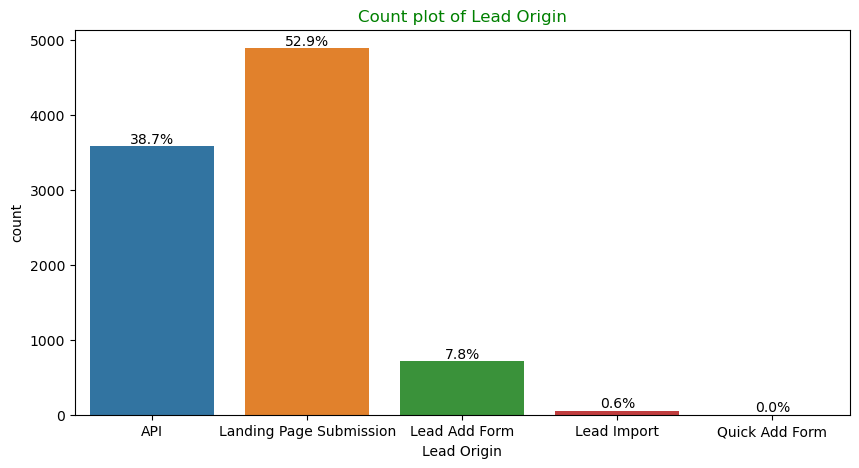

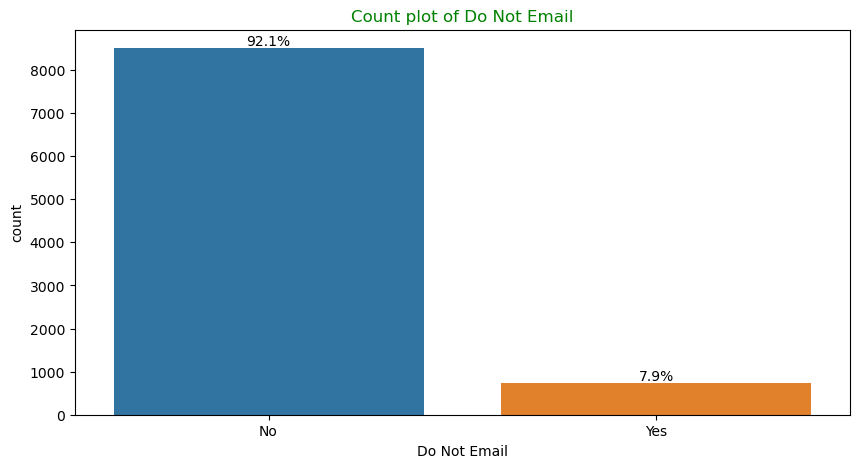

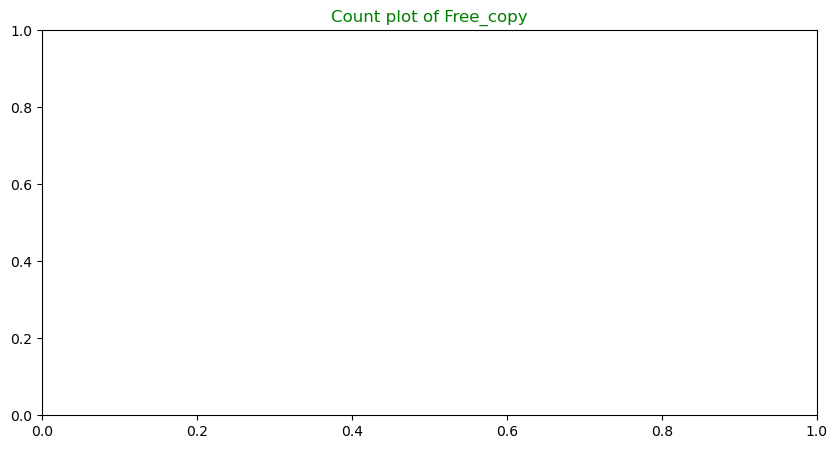

In [38]:
# countplot of columns with its value_counts percentage as annotation
for i in cat_cols[:4]:
    
    plt.figure(figsize=[10,5])
    plt.title("Count plot of {}".format(i),color="green")
    ax=sns.countplot(x=i,data=lead_df)
    total=len(lead_df[i])
    plt.xticks(rotation=0)
    
    for p in ax.patches:
        text = '{:.1f}%'.format(100*p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        
        ax.annotate(text, (x,y), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')